In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU,LSTM
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Compute technical indicators
def compute_technical_indicators(data):
    data['SMA30'] = data['Close'].rolling(window=30).mean()
    data['SMA100'] = data['Close'].rolling(window=100).mean()
    vol_window = 21
    data['Volatility'] = data['Close'].pct_change().rolling(window=vol_window).std() * np.sqrt(252)
    return data.dropna()

# Black-Scholes option pricing model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes model to generate option prices
def add_option_pricing_features(data):
    strike_price = data['Close'] * 1.05
    time_to_maturity = 30 / 252
    risk_free_rate = 0.01
    option_type = 'call'
    data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
    data['Implied_Volatility'] = data['Volatility']
    return data

# Normalize and apply PCA for dimensionality reduction
def preprocess_data(data, n_pca_components=2):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    # pca = PCA(n_components=n_pca_components)
    # data_pca = pca.fit_transform(data_scaled)
    # return np.hstack((data_scaled, data_pca))
    return data_scaled, scaler

# Create sequences for time-series prediction
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len + 1):
        sequences.append(data[i:i + seq_len + pred_len])
    return np.array(sequences)

# Function to create a Hankel matrix
def create_hankel_matrix(time_series, window_size):
    # Create a Hankel matrix where the columns are shifted versions of the time series
    hankel_matrix = np.array([time_series[i:i + window_size] for i in range(len(time_series) - window_size + 1)])
    return hankel_matrix

# Function to perform SVD on the Hankel matrix
def hankel_svd(hankel_matrix):
    # Perform SVD on the Hankel matrix
    U, Sigma, Vt = svd(hankel_matrix, full_matrices=False)
    return U, Sigma, Vt

# Build a neural network model
def build_model(input_shape, output_len):
    model = Sequential([
        # LSTM(200, return_sequences=False, input_shape=input_shape),  # LSTM layer
        # LeakyReLU(),  # Apply Leaky ReLU to LSTM outputs
        LSTM(200, activation='relu', return_sequences=False),  # LSTM layer
        Dense(180),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(output_len)  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model



def predict_and_plot(m, ticker, data, s, model, seq_len, pred_len, scaler, cut_off):
    plt.figure(figsize=(14, 7))

    rmse_values = []  # To store RMSE values for each section
    section_start_idx = []  # To store the start indices of each 30-day section for placement of RMSE labels
    #s.shape[0]
    for idx in range(0,cut_off+pred_len , pred_len):  # Loop through each 30-day block
    # for idx in range(1): # only first 30 after being trained
        # Input remains in 3D for predictio
        future_input = s[idx, :seq_len, :].reshape(1, seq_len, -1)  # Keep the 3D shape
        future = model.predict(future_input)[0]  # Predict future "Close" prices
        # Pad the prediction with zeros for the "Volume" and "SMA" columns
        future_padded = np.hstack((future.reshape(-1, 1), np.zeros((future.shape[0], data.shape[1] - 1))))  # Adjust for PCA features

        # Inverse transform the padded prediction
        future_transform = scaler.inverse_transform(future_padded)[:, 0]  # Extract "Close"

        # Extract and inverse transform the true "Close" values
        future_true = s[idx, seq_len:, 0].reshape(-1, 1)  # Use only "Close"
        future_true_padded = np.hstack((future_true, np.zeros((future_true.shape[0], data.shape[1] - 1))))  # Adjust for PCA features
        future_true_transform = scaler.inverse_transform(future_true_padded)[:, 0]  # Extract "Close"

        # Calculate RMSE for this 30-day section
        rmse = np.sqrt(mean_squared_error(future_true_transform, future_transform))
        rmse_values.append(rmse)
        section_start_idx.append(idx)  # Store the start index for the RMSE label

        # Plot the predictions
        plt.plot(np.arange(idx, idx + pred_len), future_transform, 
                # label="Train Prediction" if idx < cut_off else "Test Prediction", 
                 color="red" if idx < cut_off else "blue")

        # Plot the true values
        plt.plot(np.arange(idx, idx + pred_len), future_true_transform, 
                 #label="Train True" if idx < cut_off else "Test True", 
                 color="black" if idx < cut_off else "green")

        
    
    # Add legend and grid
    # plt.legend(["Train Prediction", "Train True", "Test Prediction", "Test True"])
    plt.plot([], [], color="red", label="Train Prediction")  # Dummy plot for legend
    plt.plot([], [], color="black", label="Train True")      # Dummy plot for legend
    plt.plot([], [], color="blue", label="Test Prediction")  # Dummy plot for legend
    plt.plot([], [], color="green", label="Test True")      # Dummy plot for legend
    plt.legend()
    for idx in range(0, s.shape[0], pred_len): 
    # Add vertical line to separate each 30-day section
        plt.axvline(x=idx + pred_len, color='gray', linestyle='--', linewidth=1)
    # Title and labels
    
    plt.title(f"{seq_len}-{pred_len} Predictions for {ticker}, model {m}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")

    # Add RMSE labels below the x-axis at the start of each 30-day section
    for i, rmse in zip(section_start_idx, rmse_values):
        plt.text(i + pred_len / 2, min(plt.ylim()), f"{rmse:.0f}", color="teal", fontsize=10, ha='center', va='top')
    plt.text(- 5- pred_len / 2, min(plt.ylim()), f"RMSE", color="teal", fontsize=10, ha='center', va='top')
    print(rmse_values)
    plt.grid(True)
    if m == "LSTM w/ 1 feature":
        dir = f"lstm/{seq_len}-{pred_len}/lstm_1"
        if not os.path.exists(dir):
                os.makedirs(dir)
        plt.savefig(f"{dir}/{ticker}.png")
    return rmse_values[-1] # testing rmse

    # plt.show()

# Call the function


# Main workflow
def main(tickers):
    m = "LSTM w/ 1 feature"
    test_rmse = []
    for ticker in tickers:
        # Step 1: Fetch data
        tsla = fetch_stock_data(ticker, start_date="2021-01-01", end_date="2024-09-30")

        # Step 2: Compute indicators
        tsla = compute_technical_indicators(tsla)

        # Step 3: Add Black-Scholes option pricing
        # tsla = add_option_pricing_features(tsla)

        # Step 4: Prepare data for training
        features = ['Close']#, 'Volume', 'SMA30', 'SMA100', 'Volatility']
        data = tsla[features].copy()
        # # Step 5: Perform Hankel Matrix Decomposition
        # window_size = 50  # Size of the sliding window to form the Hankel matrix
        # hankel_matrix = create_hankel_matrix(data['Close'].values, window_size)

        # # Step 6: Perform SVD on the Hankel matrix
        # U, Sigma, Vt = hankel_svd(hankel_matrix)

        # # You can choose the first few singular values and modes to add as features
        # num_modes = 2  # Number of modes to add as features
        # dmd_modes = U[:, :num_modes]  # Select the modes
        # dmd_amplitudes = Sigma[:num_modes]  # Select the amplitudes

        # # Step 7: Normalize and apply PCA for dimensionality reduction
        processed_data,scaler = preprocess_data(data)

        # # Trim the processed_data to match the number of rows in dmd_modes
        # processed_data_trimmed = processed_data[-dmd_modes.shape[0]:]  # Trim to match the length of dmd_modes

        # # Combine the Hankel decomposition modes with the processed data
        # data_combined = np.hstack((processed_data_trimmed, dmd_modes))

        # Step 8: Create sequences for time-series prediction
        seq_len = 6 * 30  # 6 months of data
        pred_len = 20  # Predict the next 20 days
        sequences = create_sequences(processed_data, seq_len, pred_len)

        # Step 9: Split data into training and testing
        cut_off = int(0.95 * sequences.shape[0])
        X_train = sequences[:cut_off, :seq_len, :]
        X_test = sequences[cut_off:, :seq_len, :]
        y_train = sequences[:cut_off, seq_len:, 0]
        y_test = sequences[cut_off:, seq_len:, 0]
        print(sequences.shape)
        
        # Step 10: Build and train the model
        model = build_model(input_shape=(seq_len, X_train.shape[2]), output_len=pred_len)
        history = model.fit(
            X_train, y_train,
            epochs=45 ,
            batch_size=32,
            verbose=1
        )

        test_rmse += [predict_and_plot(m, ticker, processed_data, sequences, model, seq_len, pred_len, scaler, cut_off)]

    mse_for_model  = np.mean(test_rmse)
    return mse_for_model

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0897
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0125
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0100
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0099
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0111
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0089
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0093
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0101
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0092
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0121
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0091
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0091
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0095
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0097
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0738
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0048
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0032
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0027
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0027
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0031
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0023
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0027
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0026
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0030 
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0021
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0116
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0028
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0027 
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0024

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.1463
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0124
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0118
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0098
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0079
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0096
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0082
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0110
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0081
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0083
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0077
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0112
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0098
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0085
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0081


[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.1438 
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0236
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0081
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0047
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0040
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0043
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0046
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0044
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0040
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0042
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0047
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0040
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0045
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0040
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0039


[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.1555
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0136
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0112
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0107
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0103
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0094
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0097
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0097
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0091
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0118
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0116
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0096
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0120
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0092
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0099

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.1647
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0227
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0192
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0176
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0220
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0158
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0170
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0155
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0172
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0158
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0168
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0177
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0175
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0157
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0161
E

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.1104
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0088
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0059
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0057
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0059
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0074
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0062
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0054
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0055
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0064
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0054
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0054
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0057
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0049
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0100
E

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.1221
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0099
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0112 
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0103
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0094
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0083
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0084
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0135
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0080 
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0071
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0082
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0076 
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0084 
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0075
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.1514 
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0178
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0061
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0050 
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0045
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0043 
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0043
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0042
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0049
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0046
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0045
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0083 
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0045 
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0042
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - l

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1037
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0107
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0081
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0069
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0093
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0093
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0063
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0067
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0065
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0078
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0061
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0065
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0059
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0061
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0061
E

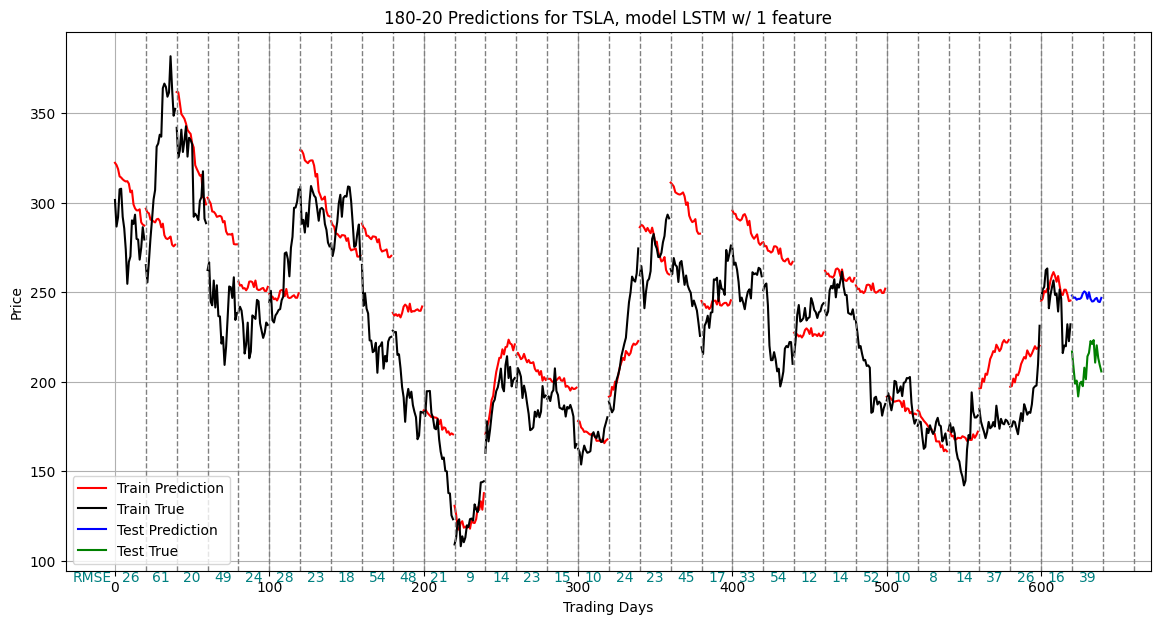

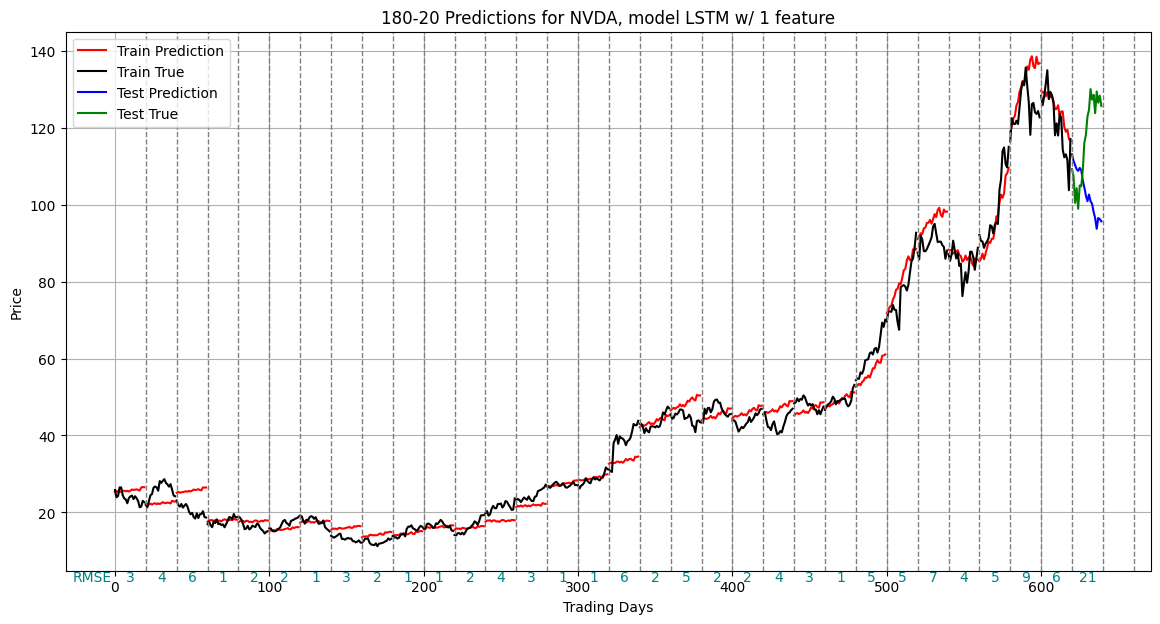

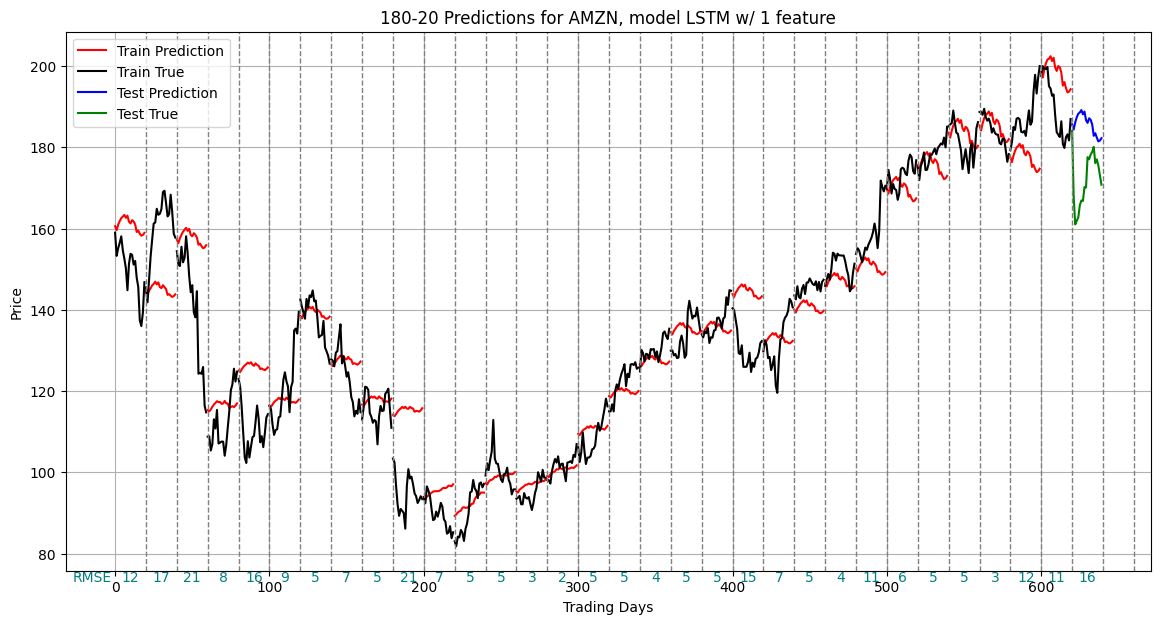

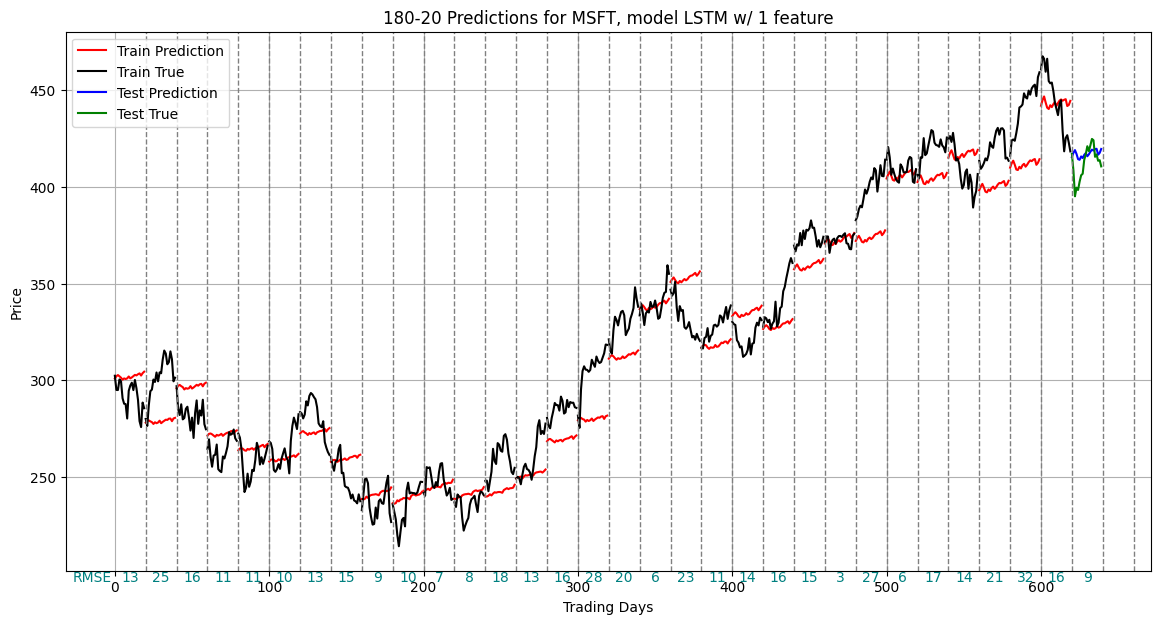

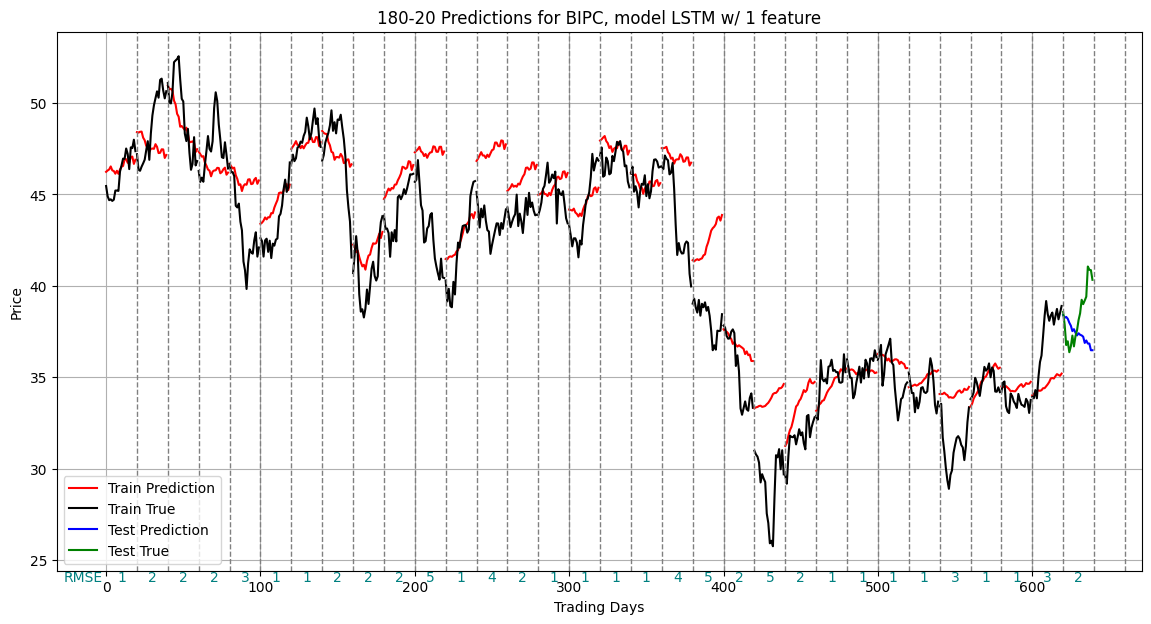

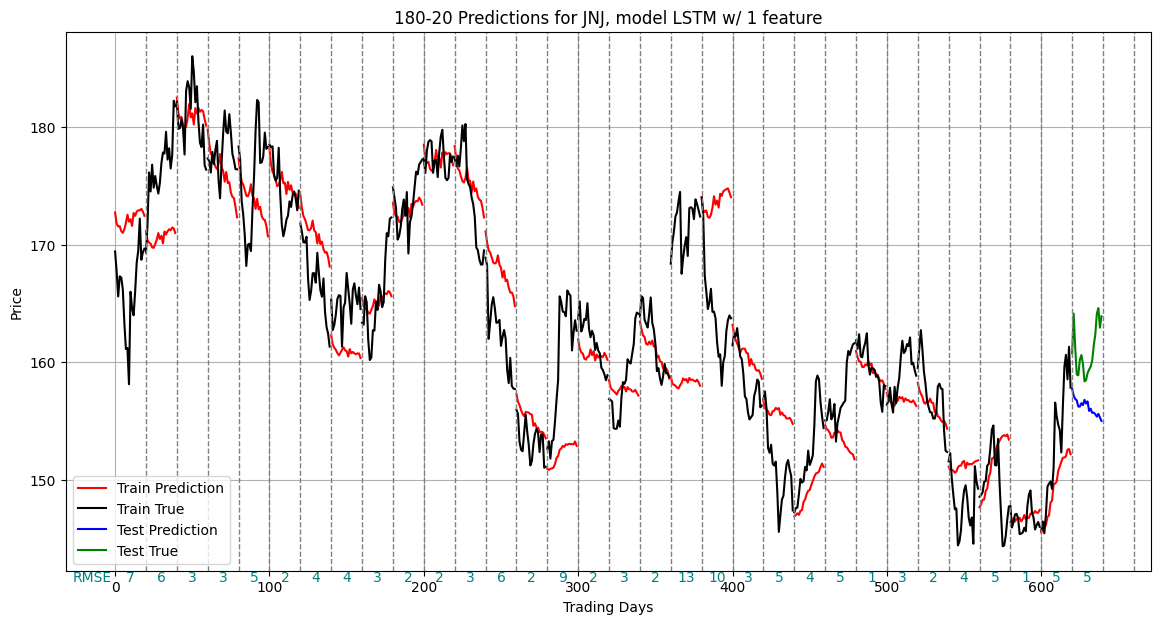

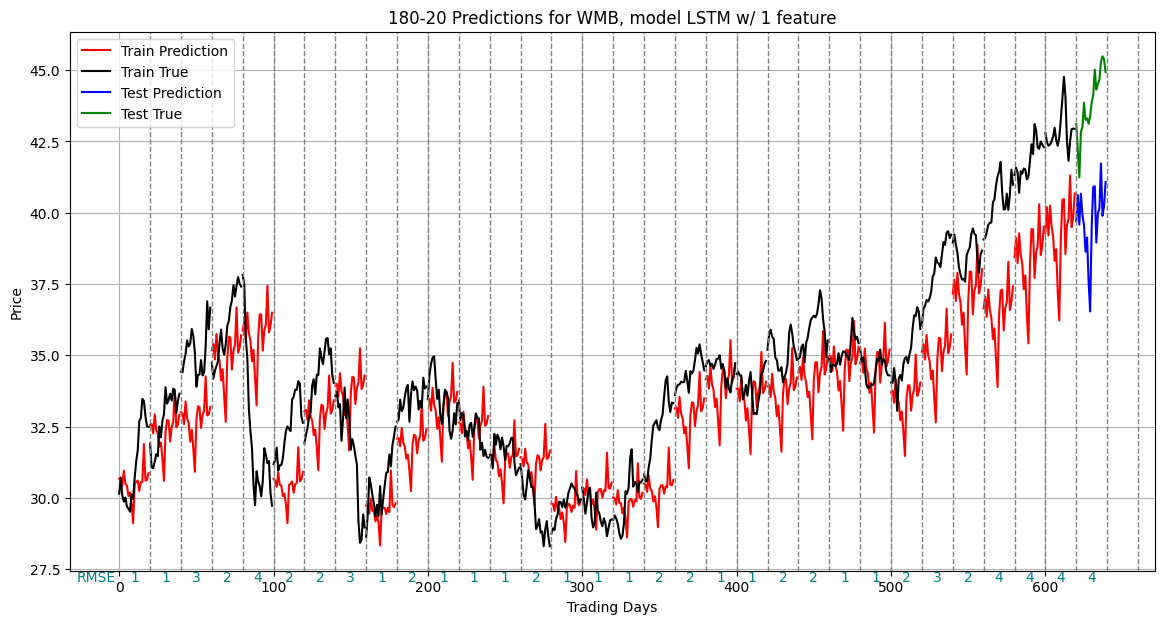

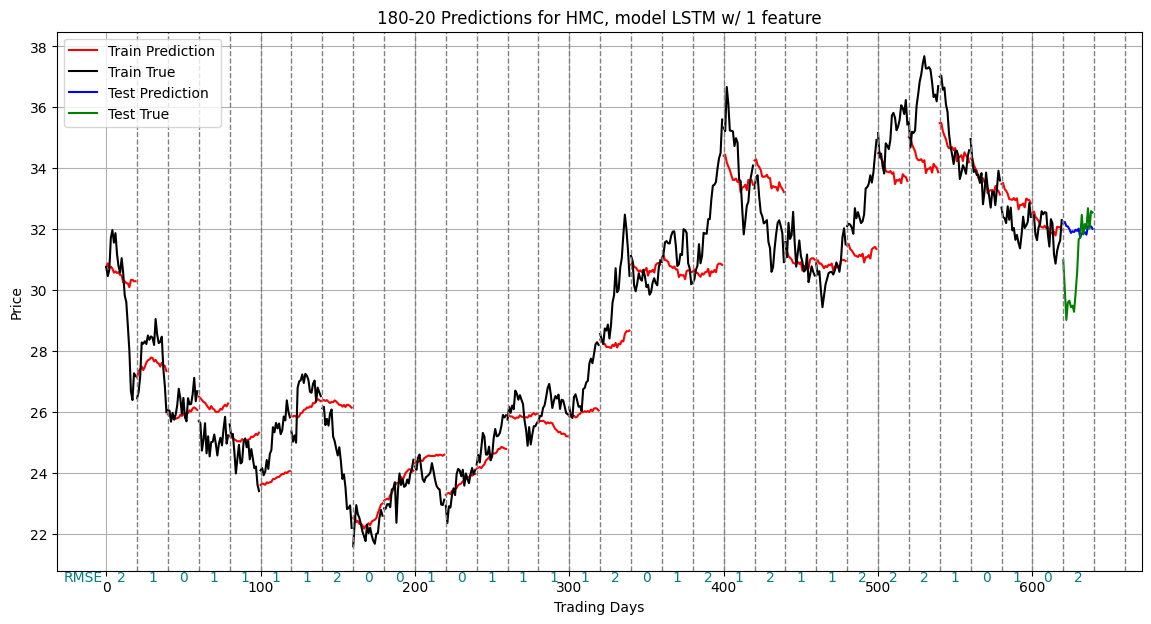

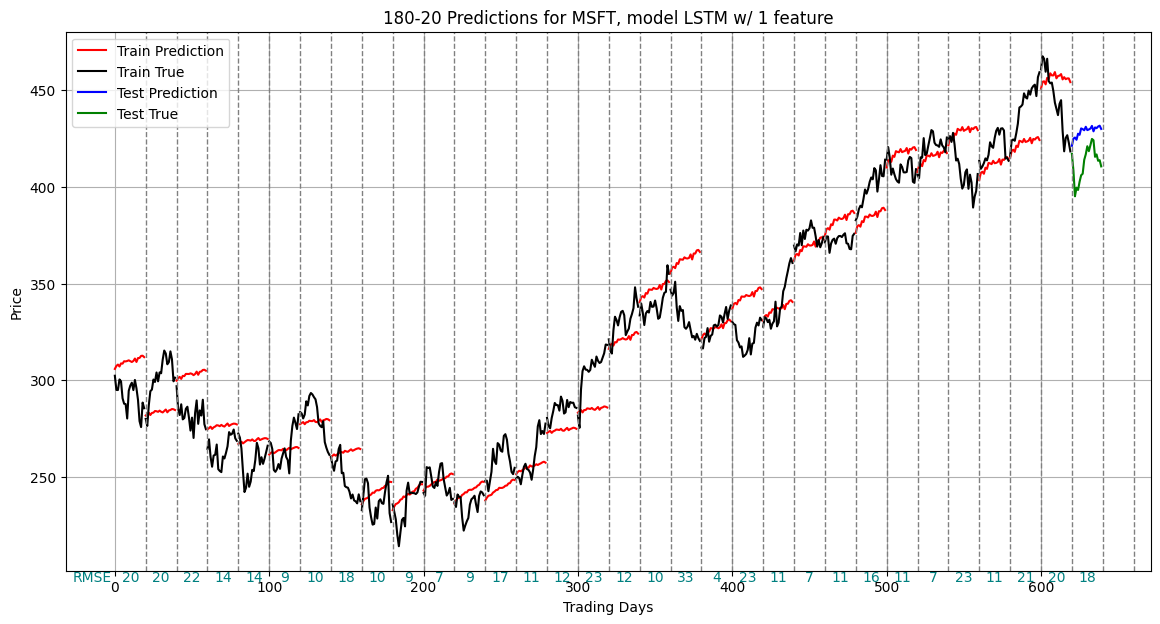

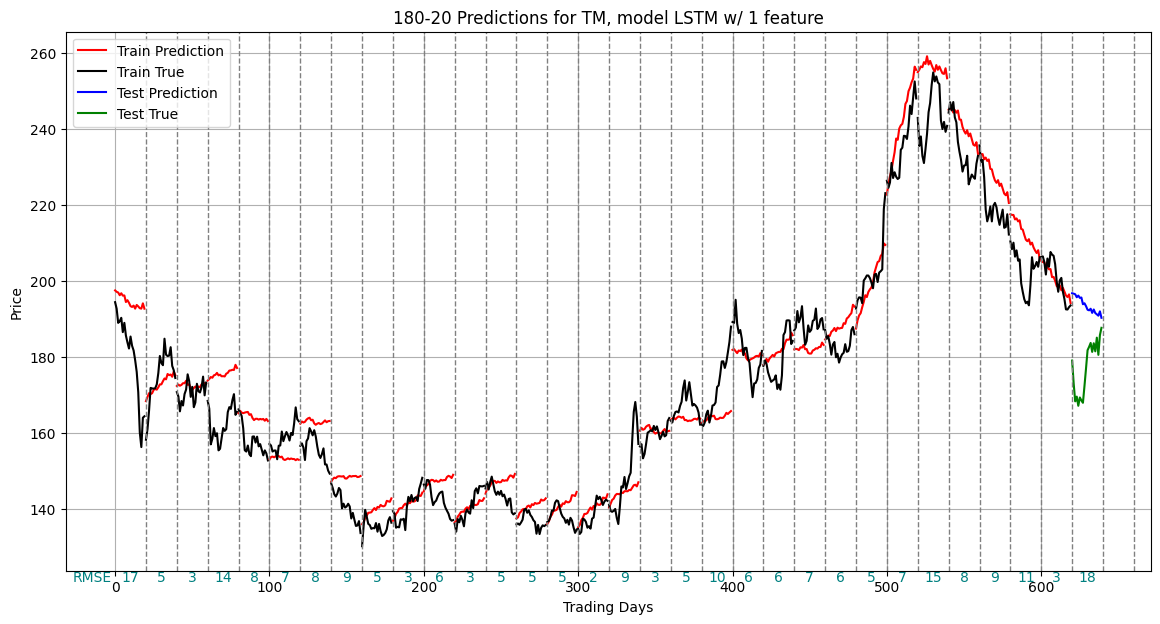

In [9]:
tickers = ["TSLA","NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"] # 
mse = main(tickers)

In [11]:
mse

13.541501473920206